<html>
 <head>
 </head>
 <body>
          <div class="alert alert-block alert-info" style="color:darkgreen;font-size:25px;text-align:center">
         <b>Deforestation Simulation and Interactive Map</b>
     </div>
                    <p style="text-align:center"> Python 3.9</p>
               <p style="text-align:center"> February 2023 </p>
     <br/>
     <a id='content'></a>
     <p style="color:blue"> <b>Contents:</b> </p>
     <a href="#1."> 1. Libraries</a><br/>
     <a href="#2."> 2. Data: Vector and Raster</a><br/>
     <a href="#3."> 3. Data pre-processing</a><br/>
     <a href="#4."> 4. Deforestation simulation by Machine Learning</a><br/>
         <a href="#4a"> &emsp; 4.a costumized model</a><br/>
         <a href="#4b"> &emsp; 4.b random forest</a><br/>
         <a href="#4c"> &emsp; 4.c knn</a><br/>
     <a href="#5."> 5. Interactive map</a><br/>
     <a href="#6."> 6. Publish map at Datapane.com</a><br/>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <p style="color:red"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; <u>Hyperlink features</u> for table of content in Github <u>does not work</u> the same way in Jupyter Notebook. <b>Just scroll down !</b></p>
     <p> </p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <p>&emsp; &#x2022; This is just a preview with low resolution to keep the notebook file small. Go to <a href="https://cloud.datapane.com/reports/q34BNqk/deforestation-simulation/"  target="_blank">Datapane.com</a> for interactive map with better quality</p>
     <br/>
 </body>
</html>

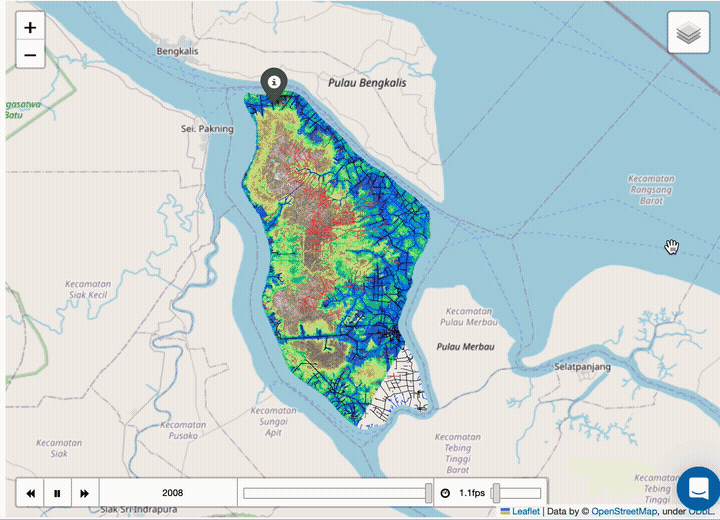

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; Simulated CHM (canopy height model) over time using Random Forest/Knn model</p>
     <br/>
 </body>
</html>

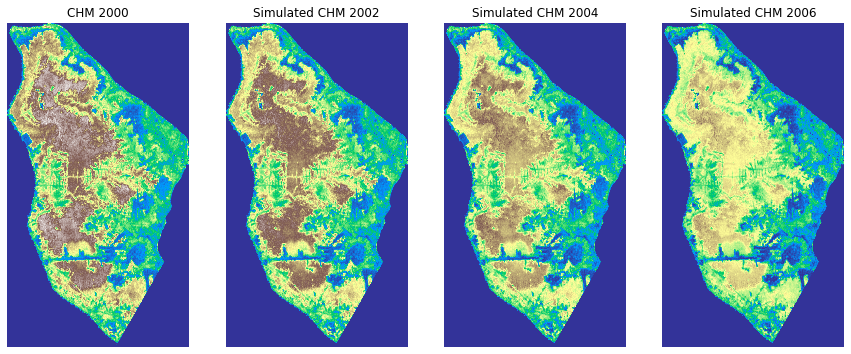

<html>
 <head>
 </head>
 <body>
          <a id='1.'></a>
     <p style="color:blue;font-size:20px"> 1. Libraries</p>
     <br/>
 </body>
</html>

In [1]:
# libraries for processing vector data

import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

In [ ]:
# library for processing raster data

from osgeo import gdal, ogr

In [2]:
# library for visualisation

import folium
from folium.plugins import TimestampedGeoJson
import matplotlib.pyplot as plt


In [3]:
# library to publish interactive map at datapane.com

import datapane as dp

In [4]:
import random

WD = '/your_path'

<html>
 <head>
 </head>
 <body>
          <a id='2.'></a>
     <p style="color:blue;font-size:20px"> 2. Data</p>
     <br/>
     <p>Vector data has 2 main classes/trails: 1) logging trails and 2) road/river</p>
     <p>&emsp; - the 'Order' attribute represent the time order in time series: 0 - 4</p>
     <p>&emsp; - Only logging trails that has dynamic time order (1 - 4)</p>
     <p>&emsp; - road/river network is set to static: timer order = 0</p>
     <br/>
     <p>Raster is a CHM (Canopy Height Model) which represent forest height in the year 2000, derived from SRTM-X 2000</p>
     <p>&emsp; - hgiher CHM represent taller forest, which is over 35 m height</p>
     <br/>
 </body>
</html>

In [10]:
# load the vector file

gdf = gpd.read_file(WD + 'sims/track_sim.shp')

# rename the header
gdf.rename(columns ={'Jenis':'trails', 'waktu':'Order'}, inplace=True)
gdf.head()

Id           trails  Order  \
0  0.0  logging track 1      2   
1  0.0  logging track 1      4   
2  0.0  logging track 1      4   
3  0.0  logging track 1      2   
4  0.0  logging track 1      2   

                                            geometry  
0  LINESTRING (200173.331 131353.196, 200543.737 ...  
1  LINESTRING (200148.191 130426.737, 200755.523 ...  
2  LINESTRING (203841.563 132095.234, 203810.278 ...  
3  LINESTRING (205045.691 132764.490, 205351.025 ...  
4  LINESTRING (205919.982 133211.646, 206110.190 ...

In [15]:
# load the raster file

raster = gdal.Open(WD + 'CHM/CHM-00.tif')
raster_band = raster.GetRasterBand(1).ReadAsArray() # the tif file has only 1 band

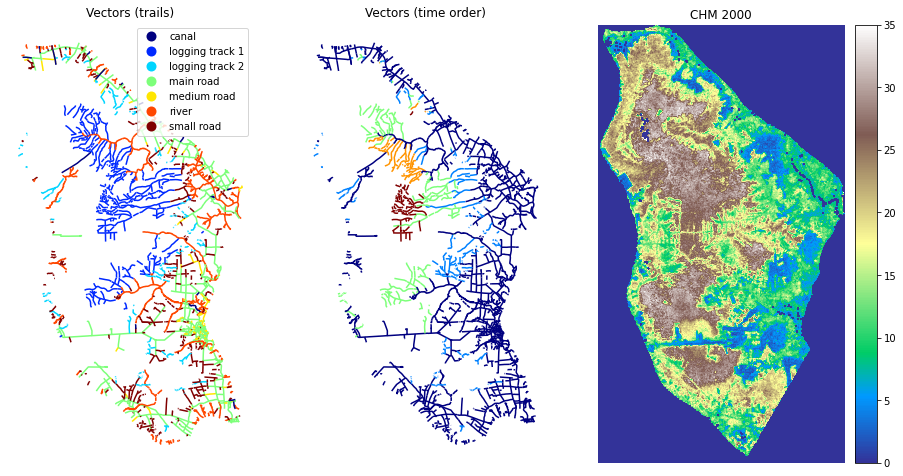

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))

gdf.plot(ax=ax1, column='trails', cmap='jet', legend=True)
ax1.set_title('Vectors (trails)')
ax1.axis('off')

gdf.plot(ax=ax2, column='Order', cmap='jet')
ax2.set_title('Vectors (time order)')
ax2.axis('off')

temp = ax3.imshow(raster_band, cmap='terrain', vmin=0, vmax=35)
ax3.set_title('CHM 2000')
ax3.axis('off')

cax = fig.add_axes([ax3.get_position().x1+0.01,
                    ax3.get_position().y0,0.02,ax3.get_position().height])
plt.colorbar(temp, cax=cax) 

This is just the preview of logging trails over time, so ignore the poor quality. Better animation is in interactive map later on 

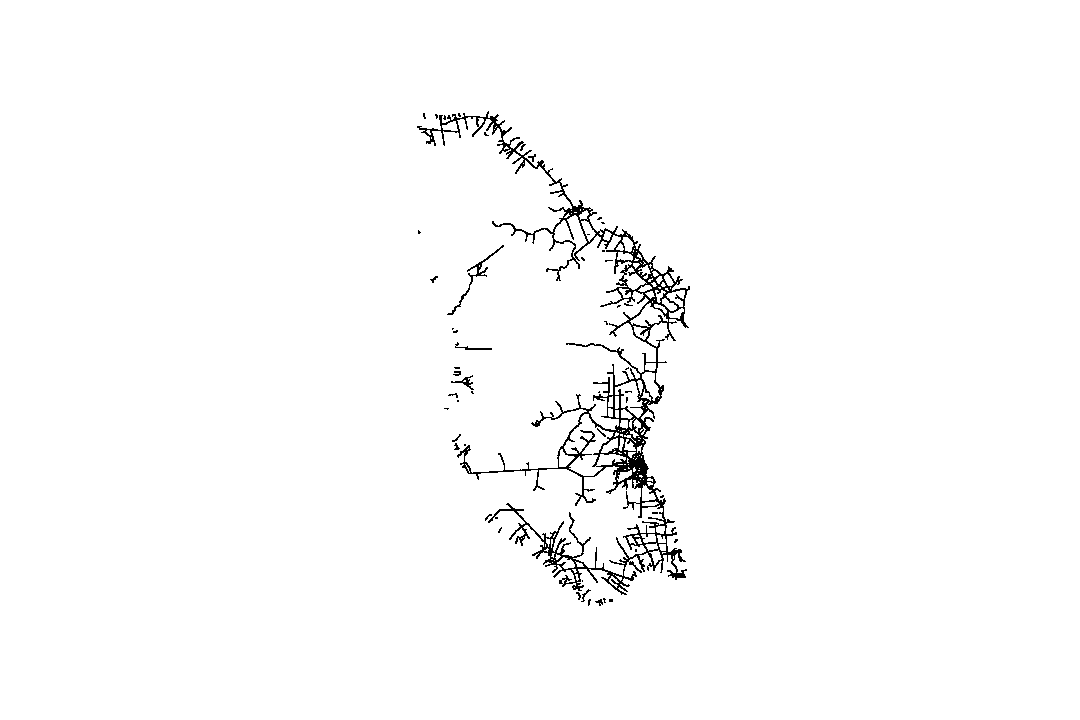

<html>
 <head>
 </head>
 <body>
          <a id='3.'></a>
     <p style="color:blue;font-size:20px"> 3. Data pre-processing</p>
     <br/>
     <p> Use GDAL Python API to rasterise vector <code>gdal.RasterizeLayer()</code> and to calculate proximity raster <code>gdal.ComputeProximity()</code> </p>
     <p>&emsp; - <a href="https://opensourceoptions.com/blog/use-python-to-convert-polygons-to-raster-with-gdal-rasterizelayer/"  target="_blank">Reference</a> for GDAL processing</p>
     <p>&emsp; - rasterised vector is needed to calculate proximity raster</p>
     <p>&emsp; - each pixel in proximity raster represent the distance form that pixel to the nearest logging trails or road/river</p>
     <br/>
 </body>
</html>

In [26]:
# load rasterised vectors

raster_2 = gdal.Open(WD + 'sims/track_ts.tif')
raster_2_band = raster_2.GetRasterBand(1).ReadAsArray() # the tif file has only 1 band

raster_3 = gdal.Open(WD + "sims/L_road.tif")
raster_3_band = raster_3.GetRasterBand(1).ReadAsArray()

(-0.5, 3156.5, 5619.5, -0.5)

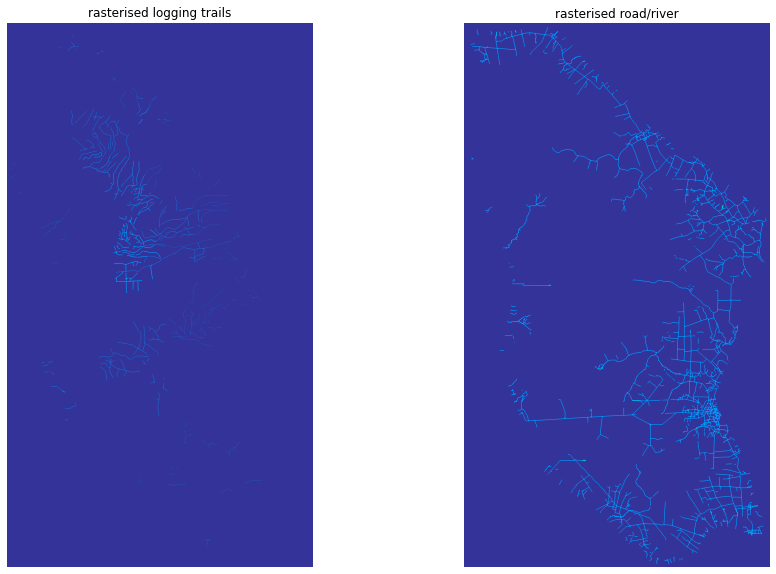

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))

ax1.imshow(raster_2_band, cmap='terrain')
ax1.set_title('rasterised logging trails')
ax1.axis('off')

ax2.imshow(raster_3_band, cmap='terrain')
ax2.set_title('rasterised road/river')
ax2.axis('off')

In [31]:
# load proximity rasters

raster_4 = gdal.Open(WD + "sims/prox-TS.tif")
prox_raster_log = raster_4.ReadAsArray()

raster_5 = gdal.Open(WD + "sims/dist_L_road.tif")
prox_raster_road = raster_5.GetRasterBand(1).ReadAsArray()

(-0.5, 3156.5, 5619.5, -0.5)

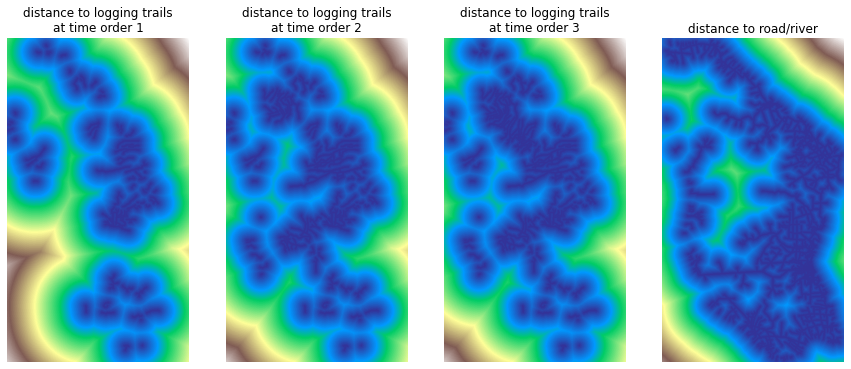

In [37]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 10))

for i in range(0,3):
    axes[i].imshow(prox_raster_log[i], cmap='terrain')
    axes[i].set_title(f'distance to logging trails\nat time order {str(i+1)}')
    axes[i].axis('off')

axes[3].imshow(prox_raster_road, cmap='terrain')
axes[3].set_title(f'distance to road/river')
axes[3].axis('off')

<html>
 <head>
 </head>
 <body>
          <a id='4.'></a>
     <p style="color:blue;font-size:20px"> 4. Deforestation simulation by Machine Learning</p>
     <p>&emsp; there are plenty of way to perform this, either by costumized model or machine learning</p>
     <p></p>
     <br/>
     <a id='4a'></a>
     <p style="color:blue"> 4.a costumized model</p>
     <p>Intuitively, area that are close to road and logging tracks has high risk of deforestation </p>
     <p>We create an inverse exponential model that reflect the diminishing impact of logging trails and road over distance </p>
 </body>
</html>

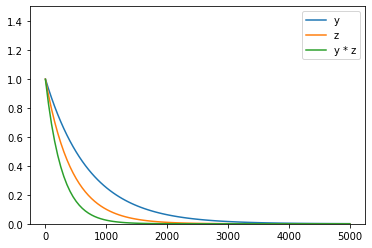

In [38]:
x = np.linspace(1, 5000, 100)
y = (1 / 4)**(x/1000)
z = (1 / 10)**(x/1000)
zz = y*z

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.plot(x, y, label='y')
plt.plot(x, z, label='z')
plt.plot(x, zz, label='y * z')
plt.ylim(0, 1.5)
plt.legend()

plt.show()

<html>
 <head>
 </head>
 <body>
     <p>The above graph ilustrate the effect of logging trails/road/river over distance (x axis in meter)</p>
     <p>&emsp; - deforestation is represented by CHM loss, or loss of canopy height model</p>
     <p>&emsp; - y axis can be set as coefficient factor for CHM loss; the closer to the logging trails/road, the higher deforestation </p>
     <p>&emsp; - the curve can be manipulated to have different treshold, e.g., either at 1 or 2 km, and either it is smooth or abrupt treshold</p>
     <p></p>
     <br/>
 </body>
</html>

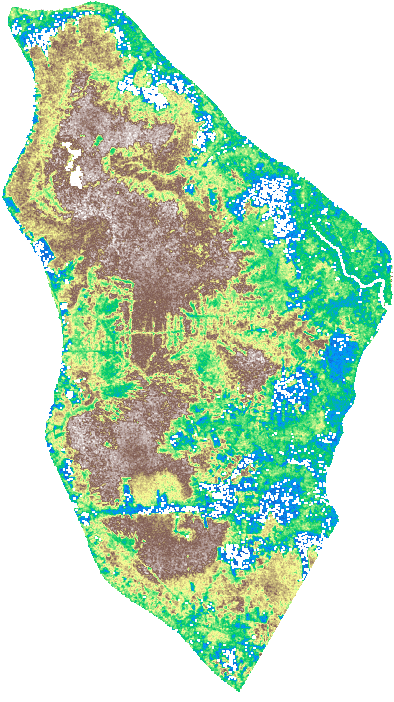

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; Area with high CHM (forest) is shrinking as logging trails are encroaching into the forest</p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <a id='4b'></a>
     <p style="color:blue"> 4.b random forest</p>
     <p>&emsp; &#x2022; This need training data</p>
     <p>&emsp; &#x2022; let use CHM from TanDEM-X 2021 as oberserved deforestation, and then feed the training data to the model</p>
 </body>
</html>

In [1]:
import pandas as pd
import numpy as np

WD = '/your_path'

In [3]:
data_ref = pd.read_csv(WD + "2023/CHM-change.csv")
data_ref[['CHM_00_11', 'pre_CHM_00', 'L_dist', 'R_dist']].head()

CHM_00_11  pre_CHM_00     L_dist      R_dist
0 -26.369162   33.660454  1243.9040   961.52280
1 -26.726244   33.688595  1266.9176   964.85565
2 -33.608600   40.056010  1294.4897   974.78590
3 -23.463820   29.087938  1326.3363   991.11505
4 -13.592302   18.802483  1362.1573  1013.53406

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; <code>CHM_00_11</code> is CHM change between CHM in 2000 (SRTM-X) and CHM in 2011 (TanDEM-X)</p>
     <p> &emsp; &#x2022; explanatory variables are then: <code>pre_CHM_00</code> (CHM in 2000 from SRTM-X), <code>L_dist</code> (raster distance to logging trails), and <code>R_dist</code> (raster distance to road/river network) </p>
     <br/>
 </body>
</html>

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [5]:
features = data_ref[['pre_CHM_00', 'L_dist', 'R_dist']].values 
dCHM = data_ref['CHM_00_11'].values
train_features, test_features, train_dCHM_obs, test_dCHM_obs = train_test_split(features, dCHM, test_size=0.3, random_state=0)

<html>
 <head>
 </head>
 <body>
          <p style="color:brown">building RF model</p>
      <p> &emsp; &#x2022; only 3 explanatory variables, so lets set max_depth to 3</p>
     <p> &emsp; &#x2022; 30% of data from the reference are used for testing</p>
     <p> </p>
     <br/>
 </body>
</html>

In [6]:
RFReg = RandomForestRegressor(n_estimators=100, max_depth = 3, n_jobs=-1, random_state=0)
RFReg.fit(train_features, train_dCHM_obs)

RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=0)

In [7]:
# model quality

dCHM_pred = RFReg.predict((test_features))

r_square_rf = metrics.r2_score(test_dCHM_obs, dCHM_pred)
r_square_rf

0.6383285169007735

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; the <code>R<sup>2</sup></code> is not bad, but nor great. For simulation, may be this is OK</p>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
          <p style="color:brown">load the rasters</p>
     <br/>
 </body>
</html>

In [11]:
ds_00 = gdal.Open(WD + 'CHM/CHM-00.tif')
band_00 = ds_00.GetRasterBand(1) 
CHM_00 = band_00.ReadAsArray()

ds_11 = gdal.Open(WD + 'CHM/CHM-11_d.tif')
band_11 = ds_11.GetRasterBand(1) 
CHM_11 = band_11.ReadAsArray()

CHM_00 = np.where((CHM_00 > 50), 0, CHM_00)
CHM_00 = np.where((CHM_00 < -50), 0, CHM_00)

ds_L = gdal.Open(WD + "sims/dist_L_trails.tif")
band_L = ds_L.GetRasterBand(1) 
raster_L = band_L.ReadAsArray()

ds_R = gdal.Open(WD + "sims/dist_L_road.tif")
band_R = ds_R.GetRasterBand(1) 
raster_R = band_R.ReadAsArray()

<html>
 <head>
 </head>
 <body>
          <p style="color:brown">use the model to predict change in CHM</p>
      <p> &emsp; &#x2022; </p>
     <br/>
 </body>
</html>

In [12]:
d3 = np.array([CHM_00, raster_L, raster_R])

array = np.stack(d3, axis=2)
array = np.reshape(array, [d3.shape[2]*d3.shape[1], d3.shape[0]])
test1 = pd.DataFrame(array, dtype='float32')

# predict CHM change
dCHM_RFReg = RFReg.predict(test1)
dCHM_model = dCHM_RFReg.reshape((d3.shape[1], d3.shape[2]))

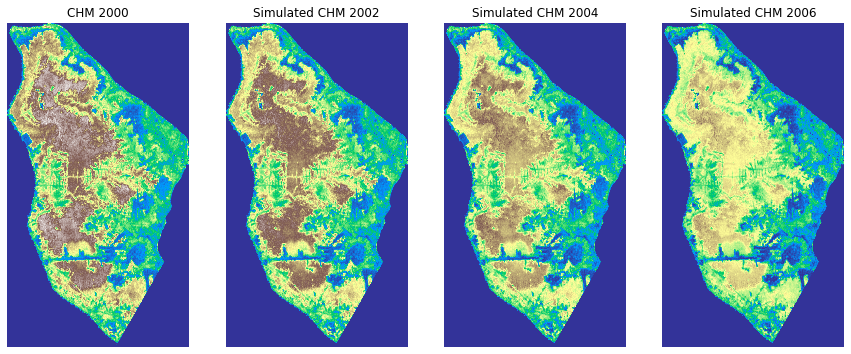

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 10))

for i in range(4):
    
    # simulating new CHM
    CHM_model = CHM_00 + (i*2*dCHM_model/10)
    ax[i].imshow(CHM_model, cmap='terrain', vmin=0, vmax=35)
    if i == 0:
        ax[i].set_title('CHM 2000')
    else:
        ax[i].set_title('Simulated CHM '+str(2000+(i*2)))
    ax[i].axis('off')

        
plt.show()

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; High CHM is slowly diminished. Effect of logging trails does not seem visible in comparison to previous model with simple regression</p>
     <p> &emsp; &#x2022; i.e., Random forest model sems overestimate the effect of logging trails far beyond the treshold of 1.5 km we set in the previous model</p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <a id='4c'></a>
     <p style="color:blue"> 4.c Knn</p>
 </body>
</html>

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing

In [ ]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(train_features, train_dCHM_obs)

In [ ]:
dCHM_pred = model.predict(test_features)

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_dCHM_obs, dCHM_pred)
rmse = sqrt(mse)
rmse

In [ ]:
# predict CHM change using KNN model

dCHM_KNNpred = model.predict(test1)
dCHM_model = dCHM_KNNpred.reshape((d3.shape[1], d3.shape[2]))

In [ ]:
CHM_11_sim = CHM_00 + dCHM_model
file_to_plot = np.array([CHM_00, CHM_11, CHM_11_sim])
label_to_plot = ['CHM 2000', 'CHM 2011', 'Simulated CHM 2011']

fig, ax = plt.subplots(ncols=3, figsize=(15, 10))

for i in range(3):
    ax[i].imshow(file_to_plot[i], cmap='terrain', vmin=0, vmax=35)
    ax[i].set_title(label_to_plot[i])
    ax[i].axis('off')

plt.show()

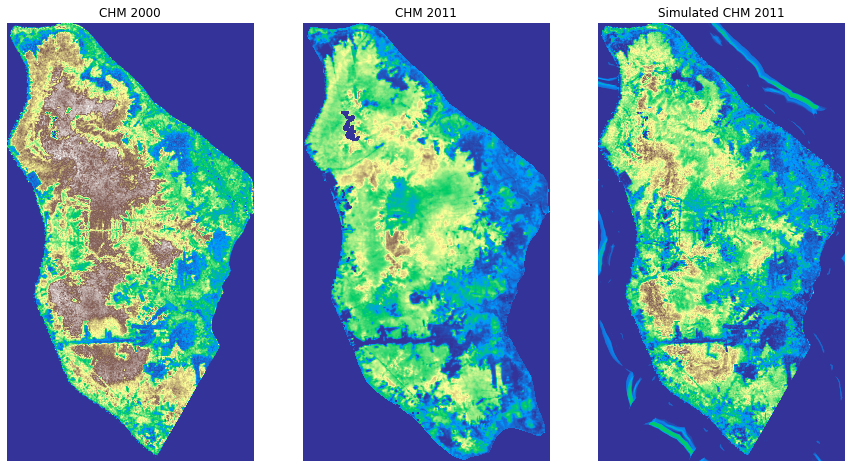

<html>
 <head>
 </head>
 <body>
     <p style="color:#8f00ff"> <b>NOTE</b></p>
     <p> &emsp; &#x2022; there is similarity between observed CHM 2011 and simulated CHM 2011</p>
     <p> &emsp; &#x2022; that is because we use CHM 11 (and CHM 00) for training data</p>
     <p>&emsp; &#x2022; the difference is in the western coast, because information of logging trails in western coast has missing</p>
     <br/>
 </body>
</html>

In [ ]:
def sim_deforestation(list_of_inputs, ML_model):
    d3 =  np.array(list_of_inputs)
    array = np.stack(d3, axis=2)
    array = np.reshape(array, [d3.shape[2]*d3.shape[1], d3.shape[0]])
    test1 = pd.DataFrame(array, dtype='float32')
    output = ML_model.predict(test1)
    output_2D = output.reshape((d3.shape[1], d3.shape[2]))
    
    return output_2D

In [ ]:
ds_L = gdal.Open(WD + "sims/prox-TS.tif")
n_band = ds_L.RasterCount
raster_L = ds_L.ReadAsArray()

raster_L.shape

In [ ]:
n_time = 6
year_interval = 2
max_L = raster_L.shape[0]

# initialise the output
n_CHM = np.empty(shape=(n_time + 1, *CHM_00.shape))
n_CHM[0,:,:] = CHM_00

for i in range(n_time):
    
    # if the simulated years go beyod the simulated proximity raster of logging trails
    # then use the last logging trails 
    if i <= max_L - 1:
        ii = i
    else:
        ii = max_L - 1
        
    dCHM = sim_deforestation([n_CHM[i], raster_L[ii], raster_R], kn_model)
    
    # append the output
    n_CHM[i+1,:,:] =  n_CHM[i] + (year_interval * dCHM/10)

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(15, 10))

for i in range(6):
    ax[i].imshow(n_CHM[i], cmap='terrain', vmin=0, vmax=35)
    if i == 0:
        ax[i].set_title('CHM '+str(2000 + (i*2)))
    else:
        ax[i].set_title('Sim. CHM '+str(2000 + (i*2)))
    ax[i].axis('off')

plt.show()

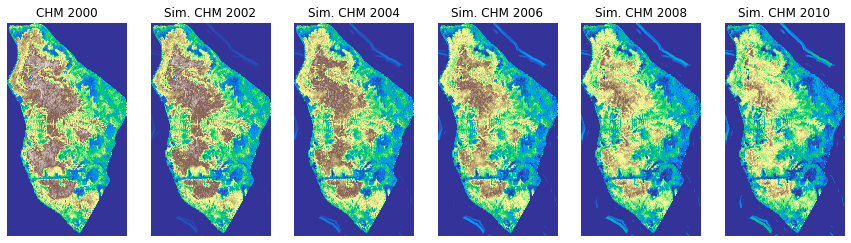

<html>
 <head>
 </head>
 <body>
          <a id='5.'></a>
     <p style="color:blue;font-size:20px"> 5. Interactive map</p>
     <p>Intuitively, area that are close to road and logging tracks has high risk of deforestation </p>
     <p>&emsp; - there are plenti of way to perform this, either by simple regression or machine learning</p>
     <p></p>
     <br/>
 </body>
</html>

In [14]:
# time series map

m = folium.Map(location=[1.1161120915099632, 102.39364522516243], zoom_start=10)

# Add  vector data in GeoJson format
# Geojson data need 'times' attribute with the correct format e.g. YYYY-MM-DD
# 'style' atribute is recomended for beter visualisation

geojson_log = gdf[['geometry','times', 'style']].to_json()

TimestampedGeoJson(
    geojson_log,
    period = 'P1Y',
    date_options='YYYY',
    transition_time=900,
    add_last_point=False,
).add_to(m)


geojson_road = road[['geometry','times', 'color']].to_json()

folium.GeoJson(
    geojson_road,
    name='Road-river network',
    style_function=lambda feature: {
        'color': feature['properties']['color'],
        'weight': 0.5 
    }
).add_to(m)

In [ ]:
img = folium.raster_layers.ImageOverlay(
    name="Deforestation simulation",
    image=WD+'sims/tes_def_sim.gif',
    bounds=[[0.9118912331078923, 102.2046745008668], [1.420091366130001, 102.48864215332074]],
    interactive=True,
    cross_origin=False,
    zindex=1,
)

# folium.Popup("I am an image").add_to(img)

img.add_to(m)
folium.LayerControl().add_to(m)

m

In [17]:
m.save('temp_Def_simulation_map.html')

<html>
 <head>
 </head>
 <body>
          <a id='6.'></a>
     <p style="color:blue;font-size:20px"> 6. Publish map at Datapane.com</p>
     <p><a href="https://docs.datapane.com/install-datapane/"  target="_blank">Reference</a> for Installation datapane library</p>
     <p>&emsp; - published map is available here at <a href="https://cloud.datapane.com/reports/q34BNqk/deforestation-simulation/"  target="_blank">Datapane.com</a></p>
     <p> &emsp; - check this <a href="https://python-visualization.github.io/folium/quickstart.html"  target="_blank">Reference</a> for adding a graph in a marker/point</p>
     <br/>
 </body>
</html>

In [18]:
app = dp.App(dp.Plot(m))
app.upload(name="Deforestation Simulation")

Uploading report and associated data - *please wait...*

Uploading files


Report successfully uploaded - view and share at <a href='https://cloud.datapane.com/reports/q34BNqk/deforestation-simulation/' target='_blank'>here</a>.

<html>
 <head>
 </head>
 <body>
     <p>This is just a preview with low resolution to keep the notebook file small. Go to <a href="https://cloud.datapane.com/reports/q34BNqk/deforestation-simulation/"  target="_blank">Datapane.com</a> for interactive map with better quality</p>
     <br/>
 </body>
</html>

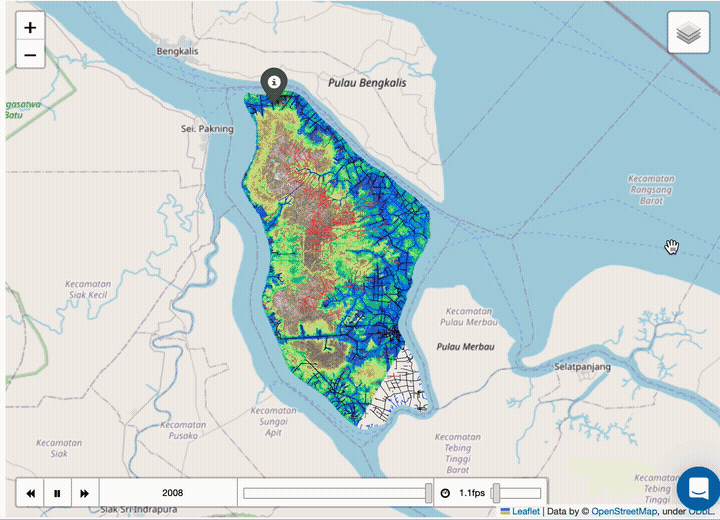